<br>
<h1 style="font-family:sans-serif; text-align:center"> 
<!--     <span style='color: pink'> Twitter analysis of </span> -->
    <span style='color: white; font-size:50%; text-shadow: 0px 0px 15px black'> Twitter analysis of </span>
<!--     <span style='color:#00acee'> Twitter analysis of </span> -->
<!--     <span style="-webkit-text-stroke"> Twitter analysis of</span> -->
<!--     <span class="hr3" style='color:#e40843; letter-spacing: 4px; font-size:105%'> Canada</span> -->
    <span class="hr3" style='color:#e40843; font-size:60%; text-shadow: 0px 0px 30px pink'>Canada </span> <span class="hr3" style='color:gray; font-size:50%; text-shadow: 0px 0px 30px pink'>response to Covid-19</span><br>
</h1>

# Sentiment Analysis

The aim of this notebook is to analyze the retrieved tweets obtained using *snscrape*, from February 1st to April 30th of 2020, from Government of Canada official Twitter accounts.

_Authors: Leo Cuspinera ([cuspime](https://github.com/cuspime)) and Victor Cuspinera ([vcuspinera](https://github.com/vcuspinera))_

## Libraries and Dataset
### Import libraries

In [1]:
# General libraries
import pandas as pd
import numpy as np
import os
import time
from datetime import datetime, timedelta, date

# To plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams["figure.figsize"] = (18,6)
import altair as alt
alt.renderers.enable('mimetype')
alt.data_transformers.disable_max_rows()

# Preprocess libraries
import re
import spacy
import string
import en_core_web_sm
nlp = en_core_web_sm.load()

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# WordCloud
from textblob import TextBlob
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# For Sentiment Analysis
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from scipy.stats import ttest_ind

# For Timeseries:
pd.plotting.register_matplotlib_converters()
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Parameters
my_folder = "../tweets/"

### Open `json` files with all tweets
You just need to run this process once time, it opens the fragmented 4 files of tweets sentiment obtained from the Python script `tweets_sentiment.py` and gather them in one only file. If you already run this section before, just jump to the next section __*Open tweets_db_sentiment.json file*__

In [3]:
%%time
START = time.time()

# Open `json` files of tweets with spaCy sentiment
df = pd.DataFrame()
for i in range(0,10):
    try:
        df_sub = pd.read_json(my_folder + 'tweets_sentiment_' + str(i) + '.json')
        df = pd.concat([df, df_sub])
    except:
        next

df.reset_index(drop=True, inplace=True)

CPU times: user 11.5 s, sys: 1.31 s, total: 12.8 s
Wall time: 13.1 s


In [4]:
# drop adds from selected usernames in cleaning_adds.ipynb notebook
adds_usernames = ["buffydragon", "mikecoulson48", "CigarGuy83", "AmbaPikin", 
                  "HaidaPrincess","andytoronto", "pattena1", "TheCigarDungeon"]

df = df[~df['username'].isin(adds_usernames)]

In [5]:
# show the data frame
df.tail(3)

account                date  replyCount  retweetCount  \
779667  @JustinTrudeau 2020-04-30 00:00:27           1             0   
779668  @JustinTrudeau 2020-04-30 00:00:19           1             0   
779669  @JustinTrudeau 2020-04-30 00:00:08           0             0   

        likeCount  quoteCount lang         sourceLabel      username  \
779667          2           0   en  Twitter for iPhone  SRodrigues52   
779668          0           0   en  Twitter for iPhone       pffoote   
779669          0           0   en     Twitter Web App  DavidCBarron   

        followersCount  friendsCount                location  \
779667             216           417              London, On   
779668             364          1535  St. John's, NL, Canada   
779669             230           332        Brampton Ontario   

                                                    tweet         day  \
779667                     @justintrudeau quit your job 🧐  2020-04-30   
779668  @rcaf_arc @cfsnowbirds @canadianforces @cfoper...  2020-04-30   
779669  @cbcnews @ctvnews @justintrudeau @celliottabil...  2020-04-30   

       announcement  polarity  subjectivity  
779667        after  0.000000      0.000000  
779668        after  0.392857      0.517857  
779669        after -1.000000      1.000000

In [6]:
# Save the final version of the tweet's database
df.to_json(my_folder + 'tweets_db_sentiment.json')

### Open `tweets_db_sentiment.json` file

In [7]:
%%time

# Open `json` file with all tweets preprocessed and with sentiment scores
df = pd.read_json(my_folder + 'tweets_db_sentiment.json')
# df = pd.read_json('/Users/leopoldo.cuspinera/Documents/Personal_projects/Canada_response_covid/tweets/' + 'tweets_db_sentiment.json')

CPU times: user 12.1 s, sys: 1.69 s, total: 13.8 s
Wall time: 13.9 s


## Analysis of all tweets
In this section we work with wordcloud and sentiment analysis of all tweets.

__Note__: Before starting to run the Analysis, we drop all with both `polarity` and `subjectivity` equals to 0.

In [8]:
# Drop tweets with both polarity and subjectivity equals to 0
df = df[~((df.polarity==0) & (df.subjectivity==0))]

### Wordcloud

In [9]:
# data and mask
allwords = ' '.join(df.tweet.values.tolist())
mask = np.array(Image.open('../img/Canadian_Flag.jpg'))

In [10]:
# get wordcloud
wcloud = WordCloud(width=3000, height=1700, random_state=11, max_font_size=211, 
                   background_color='white', max_words=400, collocations=False, 
                   mode='RGBA', mask=mask).generate(allwords)

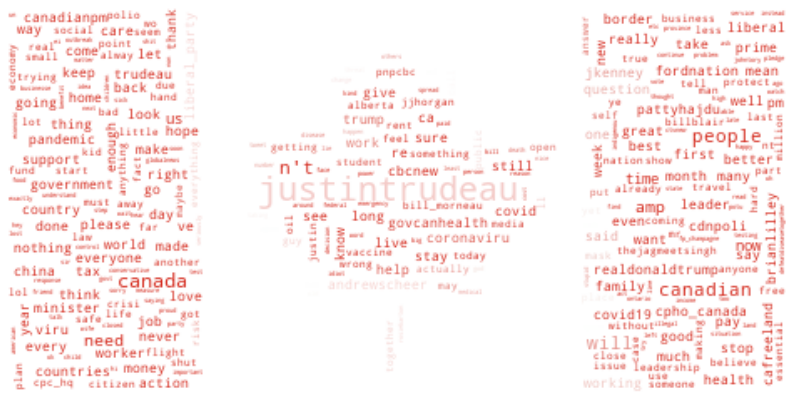

In [11]:
# plot
plt.figure(figsize=(14,8))

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.imshow(wcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file
plt.savefig("../img/canada_word_cloud.jpg", format="jpg")

> In the wordcloud we find that the most used word in the tweets is `justintrudeau`, followed by `canada`. Other words highly used in tweets as `canadian`, `people`, `amp`, `coronaviru`, `cafreeland`, `n't`.

### Repetition of tokens

In [12]:
df_weights = pd.DataFrame.from_dict(wcloud.words_, orient='index') \
               .reset_index().rename(columns={'index':'word', 0:'weight'})

In [13]:
pd.DataFrame(wcloud.layout_)[1]
df_weights.head()

word    weight
0  justintrudeau  1.000000
1         canada  0.166575
2         people  0.133925
3           will  0.129235
4            n't  0.121094

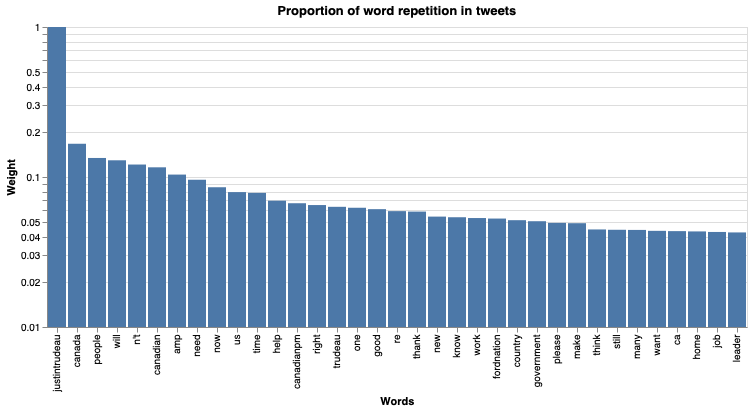

In [14]:
# plot
alt.Chart(df_weights[:35]).mark_bar().encode(
    x=alt.X('word', sort=df_weights.word.to_list(), title="Words"),
    y=alt.Y('weight', title="Weight", scale=alt.Scale(type='log')),
    tooltip=['word', 'weight']
).properties(
    title="Proportion of word repetition in tweets"
)

> In the previous plot we identify the words with higher proportion of repetitions, considering `justintrudeau` as the word more repeated in tweets. These more repeated words coincide with the biggest words in the previous word cloud.

## Analysis comparing tweets before and after Trudeau's announcement
In this section we work with wordcloud and sentiment analysis comparing results of tweets published before Trudeau's announcement, with tweets published after the announcement.

### Wordclouds

In [15]:
allwords_before = ' '.join(df[df.announcement == "before"].tweet.values.tolist())
allwords_after = ' '.join(df[df.announcement == "after"].tweet.values.tolist())

In [16]:
# get wordcloud
wcloud_before = WordCloud(width=3000, height=1700, random_state=11, max_font_size=211, background_color='white',
                max_words=400, collocations=False, mode='RGBA', mask=mask).generate(allwords_before)
wcloud_after = WordCloud(width=3000, height=1700, random_state=11, max_font_size=211, background_color='white',
                max_words=400, collocations=False, mode='RGBA', mask=mask).generate(allwords_after)

Text(0.5, 1.0, "Wordcloud of tweets before Trudeau's announcement\n")

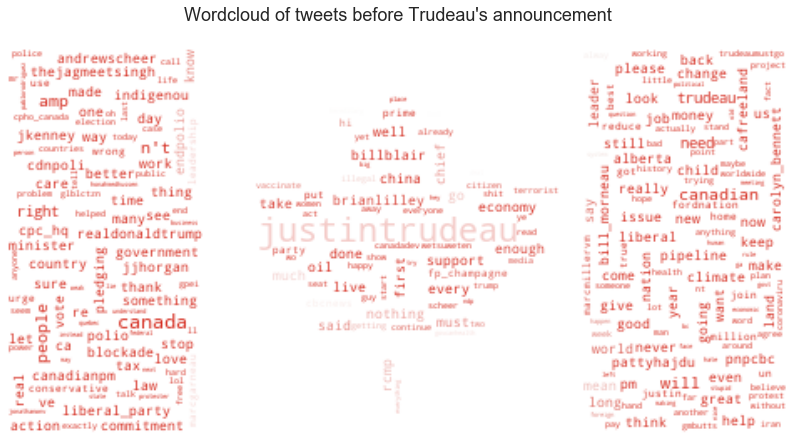

In [17]:
# Wordcloud - before Trudeau's announcement
plt.figure(figsize=(14,8))
plt.imshow(wcloud_before.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of tweets before Trudeau's announcement\n", fontsize=18)

Text(0.5, 1.0, "Wordcloud of tweets after Trudeau's announcement\n")

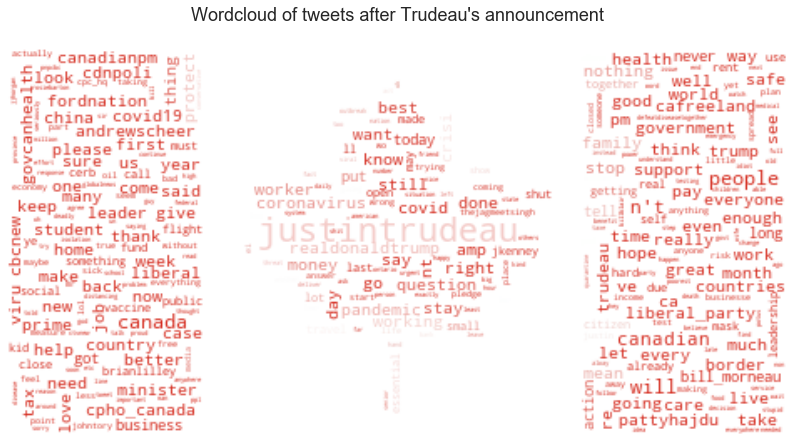

In [18]:
# Wordcloud - after Trudeau's announcement
plt.figure(figsize=(14,8))
plt.imshow(wcloud_after.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud of tweets after Trudeau's announcement\n", fontsize=18)

> When comparing the wordcloud of tweets published before Trudeau's announcement on March 11th 2020, with the wordcloud of tweets published after the announcement, it looks that the words more used are the same in both graphs.

### Repetition of tokens from tweets before and after Trudeau's announcement

In [19]:
df_w_before = pd.DataFrame.from_dict(wcloud_before.words_, orient='index') \
               .reset_index().rename(columns={'index':'word', 0:'w_before'})
df_w_after = pd.DataFrame.from_dict(wcloud_after.words_, orient='index') \
               .reset_index().rename(columns={'index':'word', 0:'w_after'})

In [20]:
df_w = pd.merge(df_w_before, df_w_after, on="word")
df_w.head(10)

word  w_before   w_after
0  justintrudeau  1.000000  1.000000
1         canada  0.188627  0.158321
2            n't  0.113799  0.123825
3       canadian  0.110372  0.118152
4            amp  0.107664  0.102329
5           will  0.105449  0.138138
6         people  0.102584  0.145657
7           need  0.079205  0.102105
8        trudeau  0.075532  0.058685
9          right  0.074185  0.061567

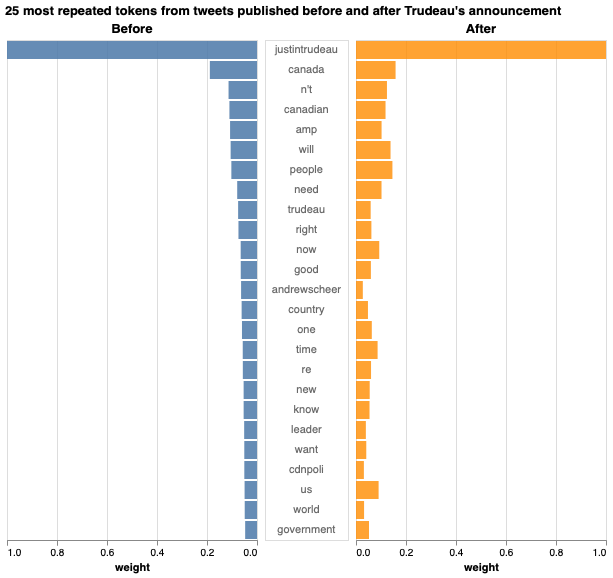

In [21]:
#plot
base = alt.Chart(df_w[:25]).properties(width=250)
my_order = df_w.word.to_list()

left = base.encode(
    y=alt.Y('word', axis=None, sort=my_order),
    x=alt.X('w_before', title='weight',
    scale=alt.Scale(reverse=True)),
    tooltip=['word', 'w_before']
).mark_bar(opacity=0.85).properties(title="Before")

middle = base.encode(
    y=alt.Y('word', axis=None, sort=my_order),
    text=alt.Text('word'),
).mark_text(color='dimgray').properties(width=83)

right = base.encode(
    y=alt.Y('word:O', axis=None, sort=my_order),
    x=alt.X('w_after', title='weight'),
    tooltip=['word', 'w_after']
).mark_bar(color='darkorange', opacity=0.8).properties(title="After")

alt.concat(left, middle, right, spacing=5)\
    .properties(title="25 most repeated tokens from tweets published before and after Trudeau's announcement")

> In general, it looks that each word have similar weights in the tweets published before and after Trudeau's announcement. Among the 25 most-repeated words, `andrewscheer`, `cdnpoly` and `liberal_party` have higher weights before the annoucement; in contrast it looks that `people`, `canadianpm`, `us` and `help` have higher weights after the annoucement.

### Sentiment anlysis by tweets - general
Exploring sentiment analysis with [SpaCy](https://spacy.io):  
- `polarity` score is a float within the range [-1.0, 1.0]
- `subjectivity` is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective

In [22]:
# polarity data
df['bin_polarity'] = pd.cut(df.polarity, bins=25)
df_bin_polarity = pd.DataFrame(df.groupby(['bin_polarity', 'announcement'])['tweet'].count()).reset_index()
df_bin_polarity.bin_polarity = [np.mean([i.left, i.right]) for i in df_bin_polarity.bin_polarity]

# subjectivity data
df['bin_subjectivity'] = pd.cut(df.subjectivity, bins=25)
df_bin_subjectivity = pd.DataFrame(df.groupby(['bin_subjectivity', 'announcement'])['tweet'].count()).reset_index()
df_bin_subjectivity.bin_subjectivity = [np.mean([i.left, i.right]) for i in df_bin_subjectivity.bin_subjectivity]

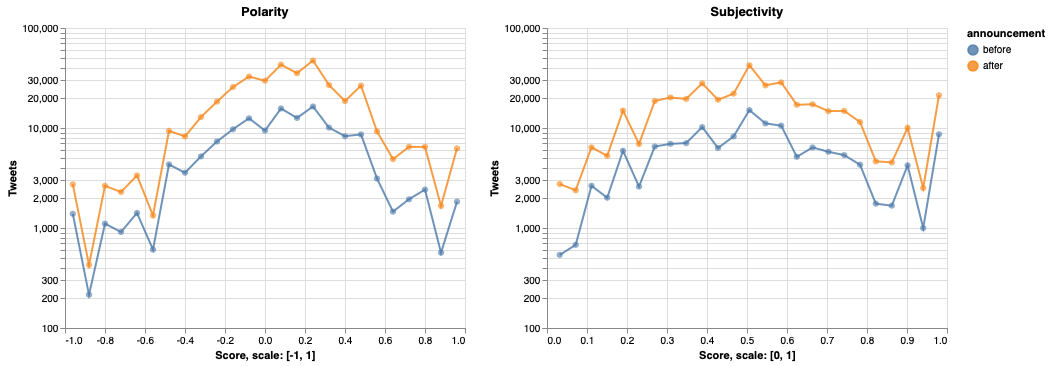

In [23]:
# polarity plot
polar = alt.Chart(df_bin_polarity).encode(
    alt.X("bin_polarity", title="Score, scale: [-1, 1]",scale=alt.Scale(domain=(-1, 1))),
    alt.Y("tweet", scale=alt.Scale(type='log'), title="Tweets"),
    alt.Color('announcement', sort=['before', 'after'])
).properties(title="Polarity")

polar_line=polar.mark_line(clip=True, opacity=0.8)
polar_point=polar.mark_circle(opacity=0.6, size=40)

# subjectivity plot
subject = alt.Chart(df_bin_subjectivity).mark_line(clip=True, opacity=0.8).encode(
    alt.X("bin_subjectivity", title="Score, scale: [0, 1]", scale=alt.Scale(domain=(0, 1))),
    alt.Y("tweet", scale=alt.Scale(type='log'), title="Tweets"),
    alt.Color('announcement', sort=['before', 'after'])
).properties(title="Subjectivity")

subject_line=subject.mark_line(clip=True, opacity=0.8)
subject_point=subject.mark_circle(opacity=0.6, size=40)

(polar_line+polar_point) | (subject_line+subject_point)

> In the previous plots we observe that the information from tweets before and after the announcement have very similar Polarity and Subjectivity curves.  
>
> In the Polarity plot, the largest number of tweets are neutral -around zero-. Beyond this, when comparing negative with positives tweets, overall we can see more positive than negative tweets, for both group of tweets (before and after the announcement). Also, it looks that users shared more tweets after the announcement than before.
>
> In the other hand, in the Subjectivity plot, the higer number of tweets were zero, which means a high number of tweets were completly objective. The second group with higher subjectivity score belong to tweets scored as 0.5 which is the half way between objective and subjective. Finally the third group of tweets with high score have a 1.0 value which means they were completly subjective. Similar to the Polarity plot, there were more tweets after the announcement than before it.
>
> Until this point, we haven't find any difference between tweets from users published before and after Trudeau's announcement.

### Sentiment anlysis by tweets - per account

#### Polarity and subjectivity per account

In [24]:
# polarity data
df_bin_polarity2 = pd.DataFrame(df.groupby(['bin_polarity', 'account', 'announcement'])['tweet'].count()).reset_index()
df_bin_polarity2.bin_polarity = [np.mean([i.left, i.right]) for i in df_bin_polarity2.bin_polarity]

# subjectivity data
df_bin_subjectivity2 = pd.DataFrame(df.groupby(['bin_subjectivity', 'account', 'announcement'])['tweet'].count()).reset_index()
df_bin_subjectivity2.bin_subjectivity = [np.mean([i.left, i.right]) for i in df_bin_subjectivity2.bin_subjectivity]

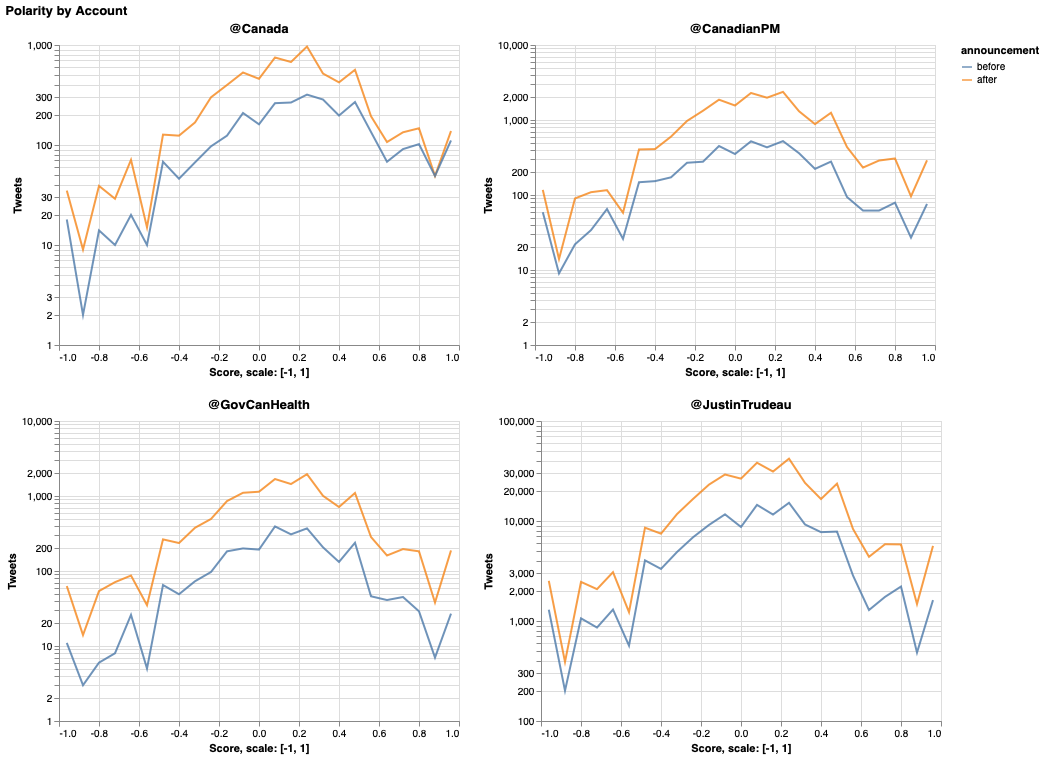

In [25]:
# polarity plots by account
plots = dict()
accounts= ['@CanadianPM', '@Canada', '@GovCanHealth', '@JustinTrudeau']
for i in accounts:#df_bin_polarity2.account.unique():
    plots[i] = alt.Chart(df_bin_polarity2[df_bin_polarity2.account == i]).mark_line(clip=True, opacity=0.8).encode(
        alt.X("bin_polarity:Q", title="Score, scale: [-1, 1]", scale=alt.Scale(domain=(-1, 1))),
        alt.Y("tweet:Q",  title="Tweets", scale=alt.Scale(type='log')),
        alt.Color('announcement', sort=['before', 'after']),
    ).properties(title=i)

((plots['@Canada']  | plots['@CanadianPM']) & \
    ((plots['@GovCanHealth'] | plots['@JustinTrudeau'])))\
    .properties(title="Polarity by Account")

The previous polarity plots by account are very similar to the general polarity plot from the previous section. In all cases both groups (tweets before and after the announcement) have similar curves for all accounts. However, something interesting is that for the GovCanHealth account tweets published before the announcement are higher than tweets after it.

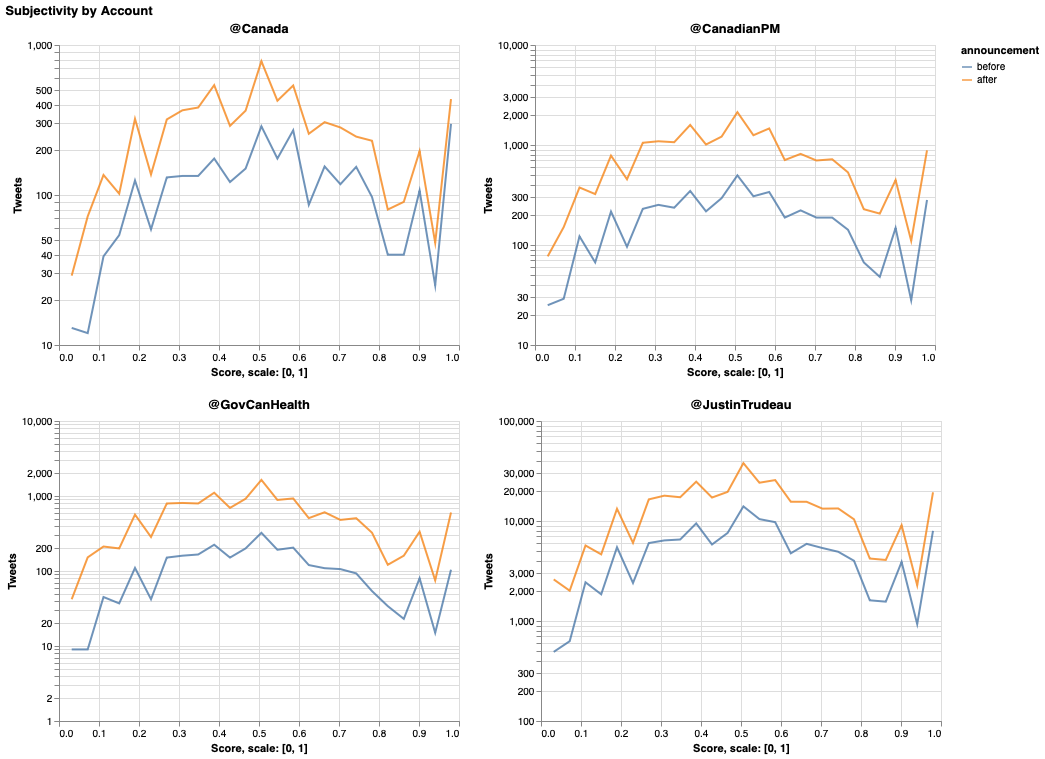

In [26]:
# subjectivity plots by account
plots = dict()
for i in df_bin_subjectivity2.account.unique():
    plots[i] = alt.Chart(df_bin_subjectivity2[df_bin_subjectivity2.account==i]).mark_line(clip=True, opacity=0.8).encode(
        alt.X("bin_subjectivity", title="Score, scale: [0, 1]", scale=alt.Scale(domain=(0, 1))),
        alt.Y("tweet", scale=alt.Scale(type='log'), title="Tweets"),
        alt.Color('announcement', sort=['before', 'after']),
    ).properties(title=i)

((plots['@Canada'] | plots['@CanadianPM']) & \
    (plots['@GovCanHealth'] | plots['@JustinTrudeau']))\
    .properties(title="Subjectivity by Account")

For subjectivity plots, also both groups have similar curves for each account, with highest value in 0.0, followed by 0.5 score.

#### Generating samples

In this section, we generate 10 thousand normal samples using the Mean and Standard deviation for each Government of Canada Twitter's account (@Canada, @JustinTrudeau, @CanadianPM, @GovCanHealth)

In [27]:
# Stats
df_stats = df.groupby(['account', 'announcement'])['polarity', 'subjectivity'].agg([pd.Series.count, np.mean, np.std]).reset_index()
df_stats

account announcement  polarity                     subjectivity  \
                                   count      mean       std        count   
0         @Canada        after    6971.0  0.156688  0.341592       6971.0   
1         @Canada       before    3000.0  0.224693  0.373104       3000.0   
2     @CanadianPM        after   19379.0  0.110747  0.329341      19379.0   
3     @CanadianPM       before    4775.0  0.079050  0.360712       4775.0   
4   @GovCanHealth        after   13743.0  0.132689  0.315507      13743.0   
5   @GovCanHealth       before    2762.0  0.130201  0.308764       2762.0   
6  @JustinTrudeau        after  342220.0  0.109374  0.346767     342220.0   
7  @JustinTrudeau       before  130210.0  0.085199  0.350821     130210.0   

                       
       mean       std  
0  0.521096  0.230819  
1  0.560314  0.243100  
2  0.503650  0.218527  
3  0.519160  0.229850  
4  0.501170  0.215883  
5  0.504304  0.208593  
6  0.523077  0.223369  
7  0.527851  0.225610

#### Polarity

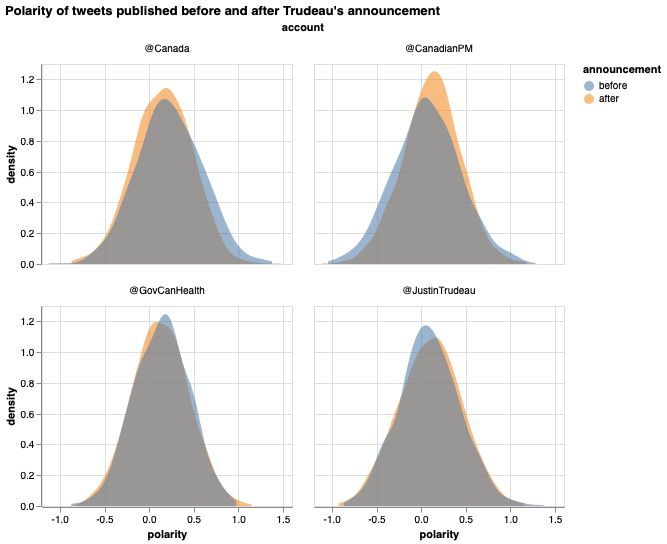

In [28]:
# Select stats for Polarity
df_stats_polar = df_stats[['polarity', 'account', 'announcement']]

# Get samples
my_dict = {}
num = 0
for i in df_stats_polar.account.unique():
    for j in df_stats_polar.announcement.unique():
        my_df = df_stats_polar[(df_stats_polar.account == i) & 
                               (df_stats_polar.announcement == j)].polarity[['mean', 'std']]
        mu = float(my_df['mean'])
        sd = float(my_df['std'])
        my_dict[num] = {
            "account": i,
            "announcement": j,
            "mu": mu,
            "sd": sd,
            "samples": np.random.normal(mu, sd, 1_000)
        }
        num += 1

df_polar_samples = pd.DataFrame()
for i in my_dict:
    df_polar_samples = pd.concat([df_polar_samples, pd.DataFrame(my_dict[i])])

df_polar_samples.reset_index(drop=True, inplace=True)

# Plot
alt.Chart(df_polar_samples, width=250, height=200).transform_density(
    'samples',
    groupby=['account', 'announcement'],
    as_=['samples', 'density']
).mark_area(opacity=0.55).encode(
    x=alt.X("samples:Q", title="polarity"),
    y='density:Q',
    color=alt.Color("announcement", sort=['before', 'after'])
).facet(
    "account",
    columns=2
).properties(
    title="Polarity of tweets published before and after Trudeau's announcement"
)

#### Subjectivity

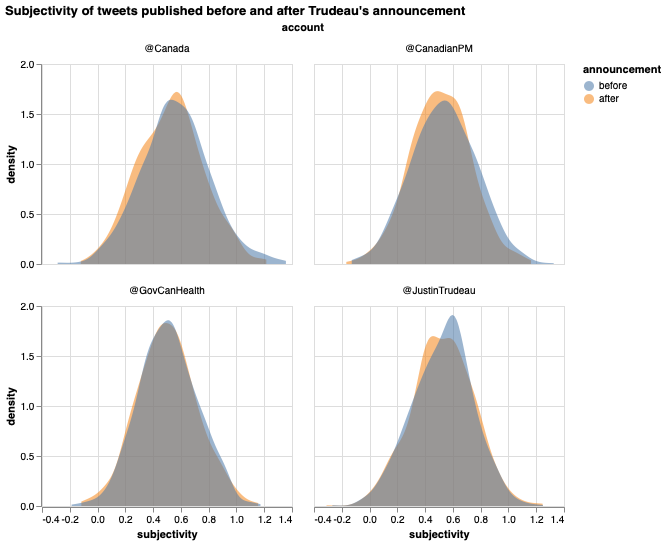

In [29]:
# Select stats for Subjectivity
df_stats_subj = df_stats[['subjectivity', 'account', 'announcement']]

# Get samples
my_dict = {}
num = 0
for i in df_stats_subj.account.unique():
    for j in df_stats_subj.announcement.unique():
        my_df = df_stats_subj[(df_stats_subj.account == i) & (df_stats_subj.announcement == j)].subjectivity[['mean', 'std']]
        mu = float(my_df['mean'])
        sd = float(my_df['std'])
        my_dict[num] = {
            "account": i,
            "announcement": j,
            "mu": mu,
            "sd": sd,
            "samples": np.random.normal(mu, sd, 1_000)
        }
        num += 1

df_subj_samples = pd.DataFrame()
for i in my_dict:
    df_subj_samples = pd.concat([df_subj_samples, pd.DataFrame(my_dict[i])])

df_subj_samples.reset_index(drop=True, inplace=True)

# Plot
alt.Chart(df_subj_samples, width=250, height=200).transform_density(
    'samples',
    groupby=['account', 'announcement'],
    as_=['samples', 'density']
).mark_area(opacity=0.55).encode(
    x=alt.X("samples:Q", title="subjectivity"),
    y='density:Q',
    color=alt.Color("announcement", sort=['before', 'after'])
).facet(
    "account",
    columns=2
).properties(
    title="Subjectivity of tweets published before and after Trudeau's announcement"
)

> When generating samples with the mean and standar deviation of the polarity and subjectivity, it looks that there is not any difference in sentiment of tweets before and after Trudeau's announcement, in any of the governments accounts.
>
> Just to be sure that, we made some hypotesis testing to know if there is some statistical difference in sentiment of tweets before vs after the annoucement.

### Hypothesis testing sentiment on tweets

In the following table we can see the general statistics all tweets, dividing them in two groups: tweets published before Trudeau's annoucement, and tweets after the announcement.
#### Testing polarity

In [30]:
# Stats from the population of tweets
df.groupby(['announcement'])['polarity'].agg([pd.Series.count, np.mean, np.std]).reset_index()

announcement     count      mean       std
0        after  382313.0  0.111144  0.344815
1       before  140747.0  0.088847  0.351502

These two groups have more than 200 Thousand tweets and, in general, any statistical test is going to be affected by a sample size this large.

So, in this case, we select a 1,000 sub-sample for each group -tweets before and after the announcement-, and use a t-test to compare the means between the two groups. 

$H_0:$ The mean polarity tweets published after Trudeau's annoucement is the same or lower than the mean polarity of tweets published before the announcement.  
$H_A:$ The mean polarity tweets published after Trudeau's annoucement is higher (with comments more positive) than the mean polarity of tweets published before the announcement.  
  
In other words:  
$H_0: \mu_{~after} \leq \mu_{~before}$  
$H_A: \mu_{~after} > \mu_{~before}$  

In [31]:
# select 1,000 tweets sample for each group, for polarity
np.random.seed(1)
df_polar_before = df[df.announcement == "before"].reset_index()[['polarity']].sample(1_000)
df_polar_after =  df[df.announcement ==  "after"].reset_index()[['polarity']].sample(1_000)

In [32]:
# hypothesis testing
ttest, pval = ttest_ind(df_polar_before, df_polar_after)
print("p-value", pval)

if pval < 0.05:
    print("We reject the null hypothesis")
else:
    print("We can't reject null hypothesis")

p-value [0.01155109]
We reject the null hypothesis


> With a sub-sample of 1,000 tweets size, we can't reject the null hypothesis: the mean polarity of tweets published after Trudeau's annoucement is the same or lower than the mean polarity of tweets published before the announcement. This result is consistent with the descriptive analysis made in the previous sections.

#### Testing subjectivity

In [33]:
# Stats from the population of tweets
df.groupby(['announcement'])['subjectivity'].agg([pd.Series.count, np.mean, np.std]).reset_index()

announcement     count      mean       std
0        after  382313.0  0.521269  0.223073
1       before  140747.0  0.527786  0.225898

Similar to the hypothesis test done for polarity, we select a 1,000 sub-sample for each group -tweets before and after the announcement-, and use a t-test to compare the means between the two groups. 

$H_0:$ The mean subjectivity tweets published after Trudeau's annoucement is the same to the mean subjectivity of tweets published before the announcement.  
$H_A:$ The mean subjectivity tweets published after Trudeau's annoucement is different to the mean subjectivity of tweets published before the announcement.  
  
In other words:  
$H_0: \mu_{~after} = \mu_{~before}$  
$H_A: \mu_{~after} \neq \mu_{~before}$  

In [34]:
# select 1,000 tweets sample for each group, for subjectivity
np.random.seed(1)
df_polar_before = df[df.announcement == "before"].reset_index()[['subjectivity']].sample(1_000)
df_polar_after =  df[df.announcement ==  "after"].reset_index()[['subjectivity']].sample(1_000)

In [35]:
# hypothesis testing
ttest, pval = ttest_ind(df_polar_before, df_polar_after)
print("p-value", pval)

if pval < 0.05:
    print("We reject the null hypothesis")
else:
    print("We can't reject null hypothesis")

p-value [0.43966522]
We can't reject null hypothesis


> Similar to the polarity analysis, with a sub-sample of 1,000 tweets size, we can't reject the null hypothesis: the mean subjectivity tweets published after Trudeau's annoucement is the same to the mean subjectivity of tweets published before the announcement. This result is also consistent with the descriptive analysis made in the previous sections.

## Time Series

In [36]:
source = df.groupby(['account', 'day'])['tweet'].count().reset_index()

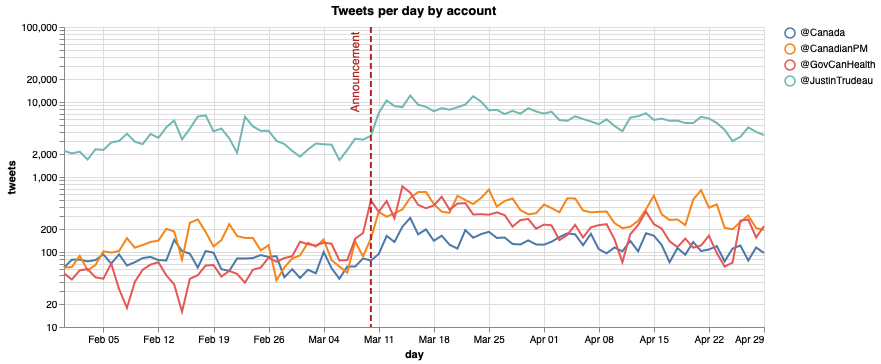

In [37]:
# Plot of tweets per day
chart = alt.Chart(source).mark_line().encode(
    alt.X('monthdate(day):T'),
    alt.Y('tweet', scale=alt.Scale(type='log')),
    alt.Color('account')
).properties(
    title="Tweets per day by account",
    width=700
)

rule = alt.Chart(pd.DataFrame({
    'day': ['2020-03-11'],
    'color': ['firebrick']
})).mark_rule(size=2, strokeDash=[6,3]).encode(
  x='monthdate(day):T',
  color=alt.Color('color:N', scale=None, title = "")
)

text = alt.Chart(pd.DataFrame({
    'day': ['2020-03-09'],
    'color': ['firebrick'],
    'y1': [25_000]
})).mark_text(
    text='Announcement', angle=270, size=12
).encode(
    alt.X('monthdate(day):T', title="day"),
    alt.Y('y1', title="tweets"),
    color=alt.Color('color:N', scale=None, title = "")
)

chart + rule + text

In [38]:
if type(df.day[0])==str:
    df.day = pd.to_datetime(df.day)

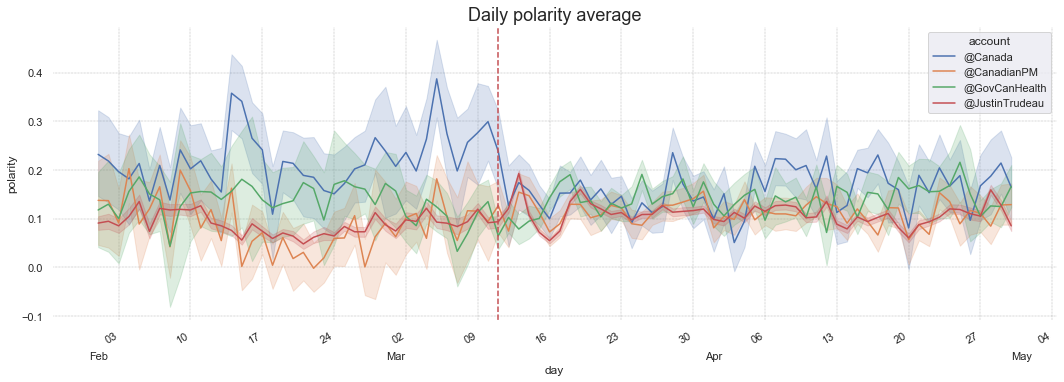

In [39]:
# Plot
fig, ax = plt.subplots()
sns.lineplot(x='day', y='polarity', hue='account', data=df, ax=ax)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n\n%b'))
ax.axvline('2020-03-11', color='r', linestyle='--')
fig.autofmt_xdate()
plt.title('Daily polarity average', size=18)
ax.set_facecolor('white')
plt.grid(color='gray', linestyle='-.', linewidth=0.3)
plt.show()

### ETS decomposition of polarity
Here we make an Error, Trend, Seasonality decomposition to check whether we have some trend or not.
First we quickly check out all of the accounts:

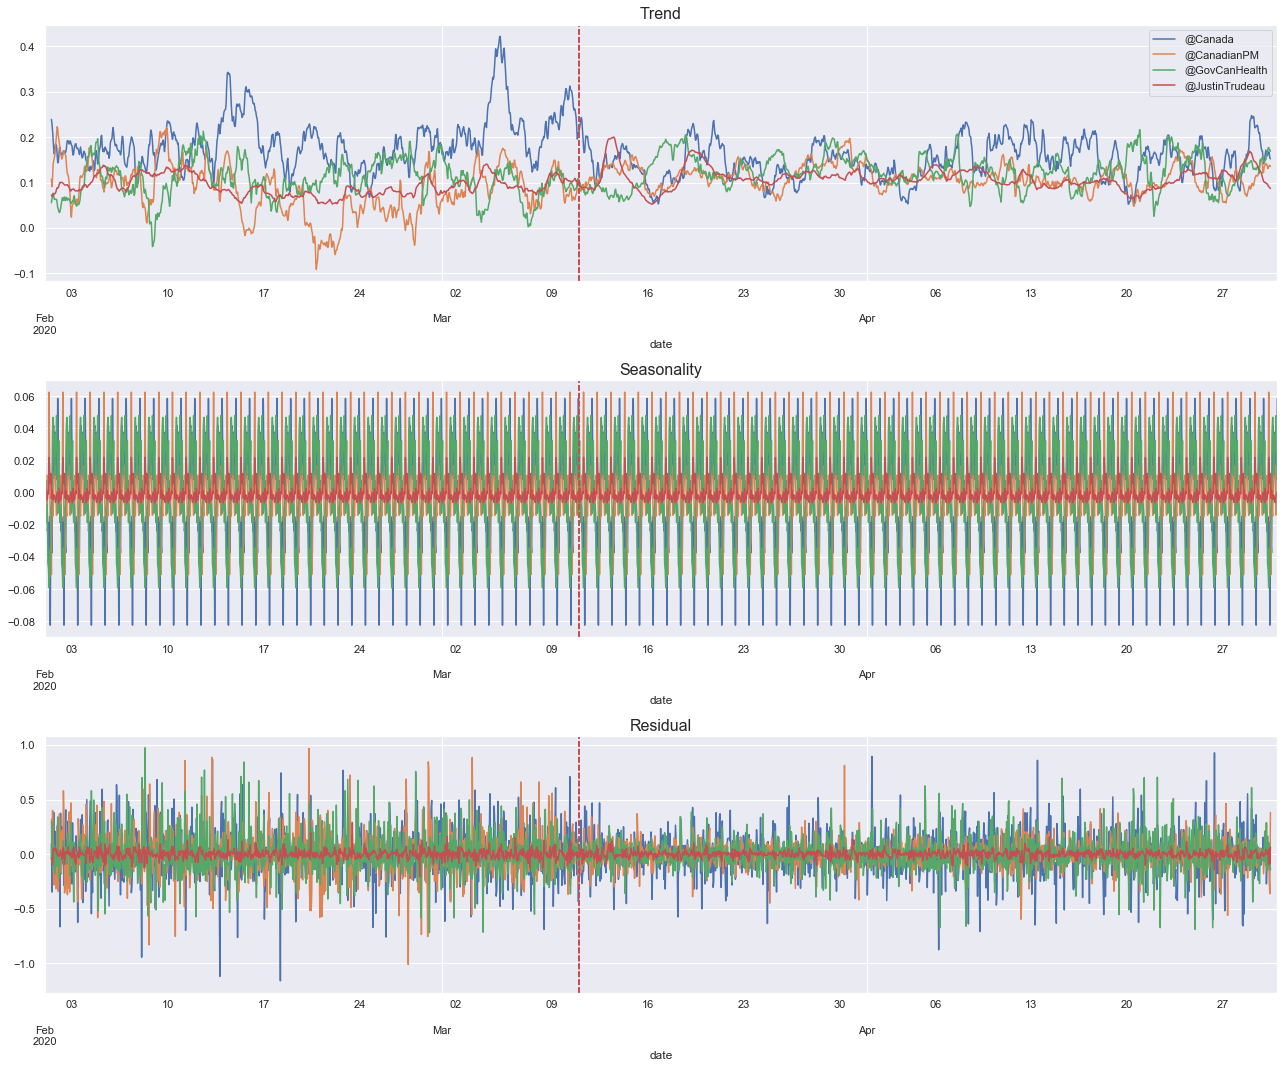

In [40]:
df_r=pd.DataFrame()
fig,ax = plt.subplots(3,1, sharex=False)
fig.set_figheight(15)
for i in df.account.unique():
    try:
        df_r = df.loc[df.account==i , ['polarity','date']].set_index('date').resample('H').mean().fillna(0)
    except ValueError:
        df_r = df.loc[df.account==i , ['polarity','date']].set_index('date').resample('D').mean().fillna(0)
    seasonal_decompose( df_r, model='additive').trend.plot(ax=ax[0], label=i);
    ax[0].set_title('Trend', size =16)
    ax[0].legend()
    ax[0].axvline('2020-03-11', color='r', linestyle='--')
    seasonal_decompose( df_r, model='additive').seasonal.plot(ax=ax[1], label=i);
    ax[1].set_title('Seasonality', size =16)
    ax[1].axvline('2020-03-11', color='r', linestyle='--')
    seasonal_decompose( df_r, model='additive').resid.plot(ax=ax[2], label=i);
    ax[2].set_title('Residual', size =16)
    ax[2].axvline('2020-03-11', color='r', linestyle='--')
plt.tight_layout();

Now, we focus on the trend only

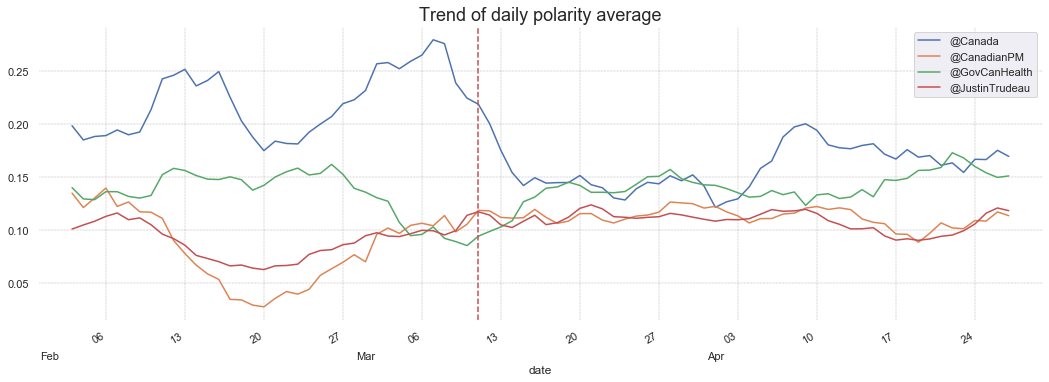

In [41]:
# Plot with trend  of daily polarity average
fig, ax = plt.subplots()
df_dic={}
for i in df.account.unique():
    try:
        df_r = df.loc[df.account==i , ['polarity','date']].set_index('date').resample('D').mean().fillna(0)
    except:
        pass
    df_dic[i] = seasonal_decompose( df_r, model='additive').trend
    df_dic[i].plot(ax=ax, label=i);

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n\n%b'))
ax.axvline(pd.to_datetime('2020-03-11'), color='r', linestyle='--')
ax.legend()
ax.yaxis.set_label('Daily polarity average')
fig.autofmt_xdate()
plt.title('Trend of daily polarity average', size=18)
ax.set_facecolor('white')
plt.grid(color='gray', linestyle='-.', linewidth=0.3)
plt.show()

This is interesting, while before March 11th tweets polarity of @Canada was the highest in range of [0.125, 0.175], @GovCanHealth level was in a range of [0.050, 0.100], and both @CanadianPM and @JustinTrudeau in a range of [0.025, 0.075]. The levels of the four accounts stabilized after March 11th around [0.075, 0.125] level.

This means that the annoucement effect on @Canada was a decrease in average polarity, but an slight rise in the sentiment tweets related with the Canadian Prime Minister which is reflected in the  polarity levels of @CanadianPM and @JustinTrudeau accounts.

For the time being, let's focus a little bit more on days that were closer to the 11th:

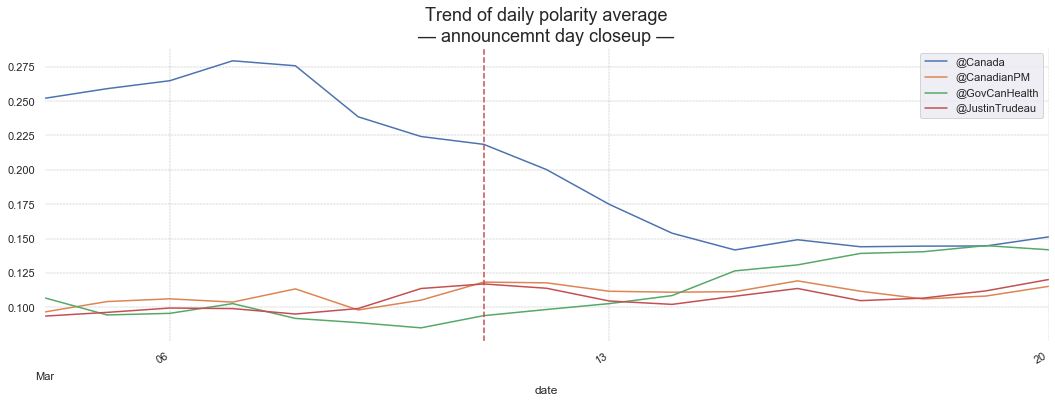

In [42]:
# Plot with trend of daily polarity average, with close up around Trudeau's annoucement
fig, ax = plt.subplots()
lower_bound='2020-03-03'
upper_bound='2020-03-21'
for i in df_dic.keys():
    df_dic[i][(df_dic[i].index>lower_bound)&(df_dic[i].index<upper_bound)].plot(ax=ax, label=i);

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n\n%b'))
ax.axvline(pd.to_datetime('2020-03-11'), color='r', linestyle='--')
ax.legend()
ax.yaxis.set_label('Daily polarity average')
fig.autofmt_xdate()
plt.title("Trend of daily polarity average\n— announcemnt day closeup —", size=18)
ax.set_facecolor('white')
plt.grid(color='gray', linestyle='-.', linewidth=0.3)
plt.show()

In [43]:
pd.DataFrame(df_dic).transpose()

date            2020-02-01  2020-02-02  2020-02-03  2020-02-04  2020-02-05  \
@Canada                NaN         NaN         NaN    0.198137    0.184738   
@CanadianPM            NaN         NaN         NaN    0.134587    0.120964   
@GovCanHealth          NaN         NaN         NaN    0.139724    0.129093   
@JustinTrudeau         NaN         NaN         NaN    0.100660    0.104516   

date            2020-02-06  2020-02-07  2020-02-08  2020-02-09  2020-02-10  \
@Canada           0.188011    0.188853    0.194150    0.189614    0.192249   
@CanadianPM       0.129908    0.139385    0.121986    0.126214    0.116940   
@GovCanHealth     0.128401    0.135923    0.135911    0.131469    0.129857   
@JustinTrudeau    0.108009    0.112669    0.115819    0.109523    0.111175   

date            ...  2020-04-21  2020-04-22  2020-04-23  2020-04-24  \
@Canada         ...    0.160837    0.163088    0.154099    0.166491   
@CanadianPM     ...    0.106477    0.101725    0.101009    0.108716   
@GovCanHealth   ...    0.158761    0.172644    0.167779    0.159706   
@JustinTrudeau  ...    0.093814    0.094989    0.099044    0.105427   

date            2020-04-25  2020-04-26  2020-04-27  2020-04-28  2020-04-29  \
@Canada           0.166241    0.174946    0.169244         NaN         NaN   
@CanadianPM       0.108198    0.116823    0.113309         NaN         NaN   
@GovCanHealth     0.153724    0.149385    0.150800         NaN         NaN   
@JustinTrudeau    0.115646    0.120546    0.117996         NaN         NaN   

date            2020-04-30  
@Canada                NaN  
@CanadianPM            NaN  
@GovCanHealth          NaN  
@JustinTrudeau         NaN  

[4 rows x 90 columns]

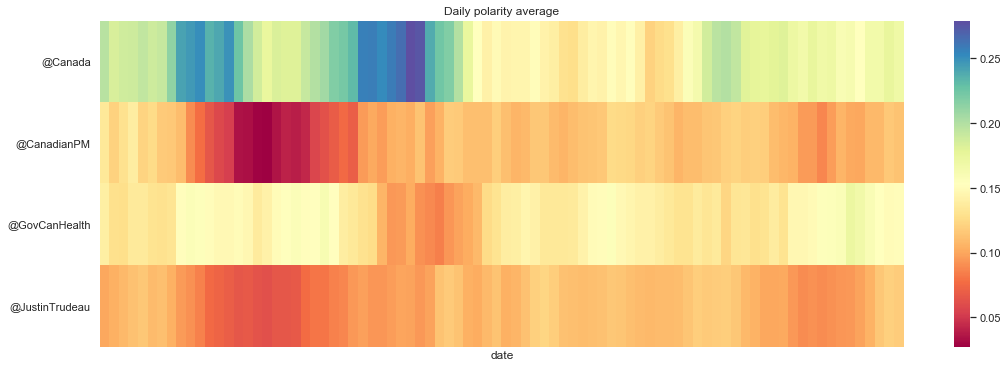

In [44]:
# Daily polarity average
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(df_dic)[3:-3].transpose(), cmap="Spectral", ax=ax);
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n\n%b'))
ax.set_title('Daily polarity average');
# ax.axvline(pd.to_datetime('2020-03-25'), color='r', linestyle='--')  #<<< THIS LINE IS NOT WORKING

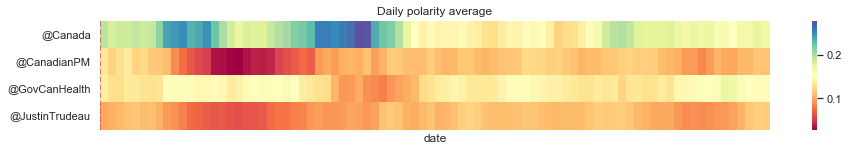

In [45]:
# Daily polarity average
def heatmap_options():
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=0))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n\n%b'))
    ax.set_title('Daily polarity average');
    ax.axvline('2020-03-11', color='r', linestyle='--')  #<<< THIS LINE IS NOT WORKING
    
fig, ax = plt.subplots(figsize=(15,2))
sns.heatmap(pd.DataFrame(df_dic)[3:-3].transpose(), cmap="Spectral", ax=ax);
heatmap_options()

Nice but the color code is still making us compare what people thought about *Canada* with what people thought about *Justin Trudeau*. 

Maybe we can actually make things more independent.

### Normalising so that every account has a minimum of 0 and a max of 1
This would help us seeing the polarity variations at first sight for each individual account

In [46]:
norm = pd.DataFrame(df_dic)[3:-3] - pd.DataFrame(df_dic)[3:-3].min(axis=0)
norm = norm.div( (pd.DataFrame(df_dic)[3:-3].max(axis=0)-pd.DataFrame(df_dic)[3:-3].min(axis=0)), axis=1)
norm.describe()

@Canada  @CanadianPM  @GovCanHealth  @JustinTrudeau
count  84.000000    84.000000      84.000000       84.000000
mean    0.410496     0.647247       0.592621        0.621236
std     0.249994     0.241838       0.213423        0.260387
min     0.000000     0.000000       0.000000        0.000000
25%     0.203602     0.612690       0.523252        0.502067
50%     0.375572     0.734170       0.615834        0.691393
75%     0.552151     0.798882       0.741128        0.816842
max     1.000000     1.000000       1.000000        1.000000

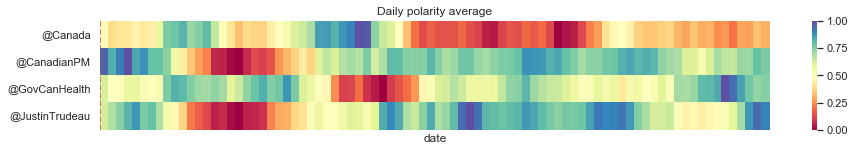

In [47]:
fig, ax = plt.subplots(figsize=(15,2))
sns.heatmap(norm.transpose(), cmap="Spectral", ax=ax);
heatmap_options()

This is a bit of a but bumpy ride. Let's try to smoothen things out my plotting a moving average:

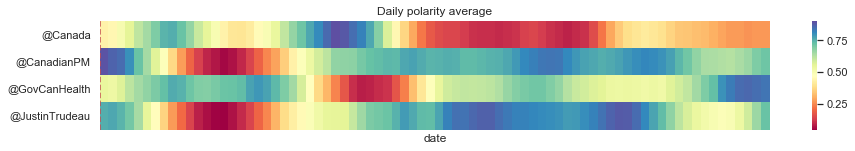

In [48]:
fig, ax = plt.subplots(figsize=(15,2))
sns.heatmap(norm.rolling(window=7).mean().dropna().transpose(), cmap="Spectral", ax=ax);
heatmap_options()

## Volume of tweets

### ETS decomposition

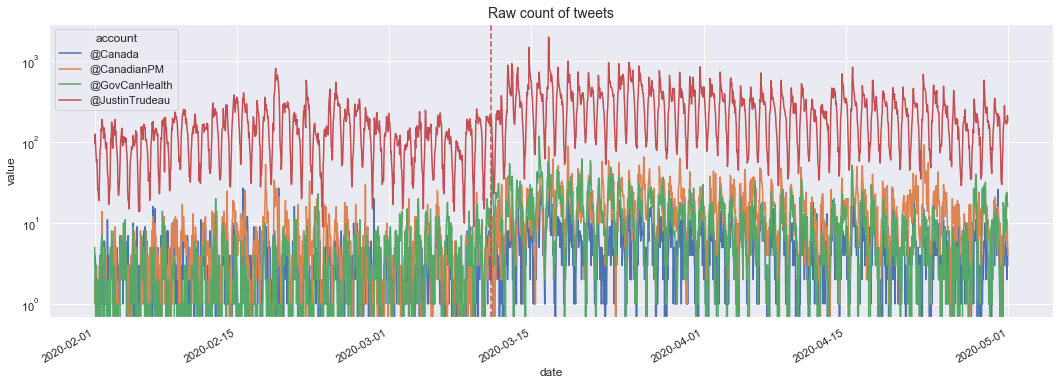

In [49]:
plt.rcParams["figure.figsize"] = (18,6)
# idx = pd.date_range(start=df.date.min(), end=df.date.max(), freq='D')

# Set the dataframe we will be using 
df1 = pd.DataFrame()
for i in df.account.unique().tolist():
    df1[i] = (df.loc[df.account==i , ['polarity','date']].set_index('date').resample('H').count().fillna(0)).polarity
df1 = df1.reset_index().melt(id_vars=['date'],var_name='account').set_index('date')

# Plot
fig, ax = plt.subplots()
sns.lineplot(x=df1.index, y='value', hue='account', data=df1, ax=ax)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set(yscale='log')
fig.autofmt_xdate()
ax.set_title('Raw count of tweets', size=14)
ax.axvline(pd.to_datetime('2020-03-11'), color='r', linestyle='--')

plt.show()

This is nice to see but it's still somewhat hard to understand the trend. If we decompose it like we've already done for polarity we might understand it better.

### Trend of tweet count

[None]

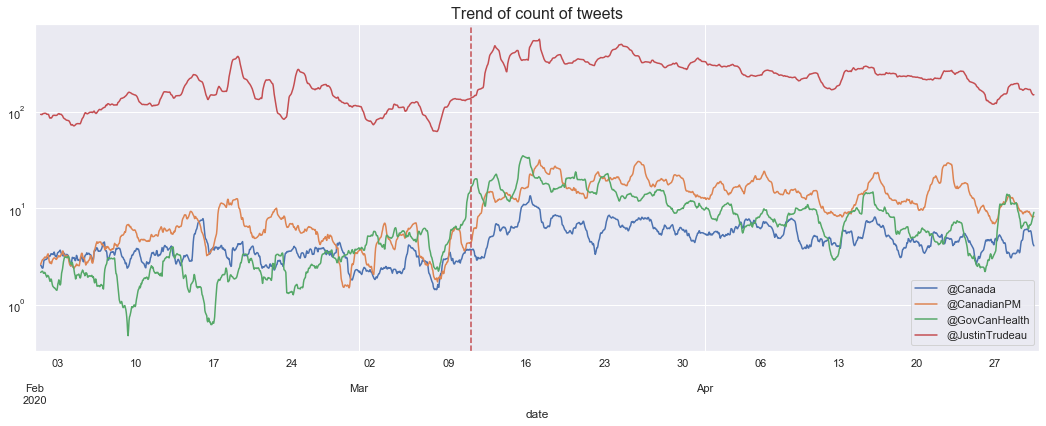

In [50]:
fig, ax = plt.subplots()

for acc in df.account.unique().tolist():
    seasonal_decompose(df1[df1.account==acc].value, model='additive').trend.plot(ax=ax);
plt.title('Trend of count of tweets', size = 16);
plt.legend(df.account.unique().tolist())
ax.axvline(pd.to_datetime('2020-03-11'), color='r', linestyle='--')
ax.set(yscale='log')

### Total volume of tweets

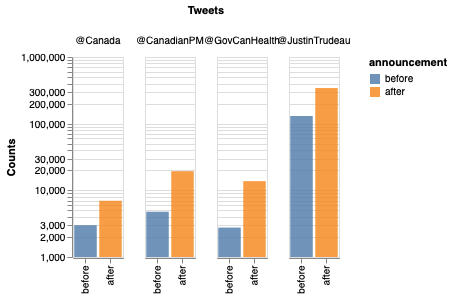

In [51]:
# plot volume of tweets 
df_volume = df.groupby(['account', 'announcement'])['tweet'].agg([pd.Series.count]).reset_index()
alt.Chart(df_volume, width=50, height=200).mark_bar(opacity=0.8).encode(
    x=alt.X('announcement', sort=['before', 'after'], title=""),
    y=alt.Y('count', title="Counts", scale=alt.Scale(type='log')), 
    color=alt.Color('announcement', sort=['before', 'after']),
    column=alt.Column('account', title="Tweets"),
    tooltip=['account', 'announcement', 'count']
)

> When comparing the volume of tweets published before and after, we find that Trudeau's announcement had an impact in the number of tweets of users that mention any of the Canadian Government's account.

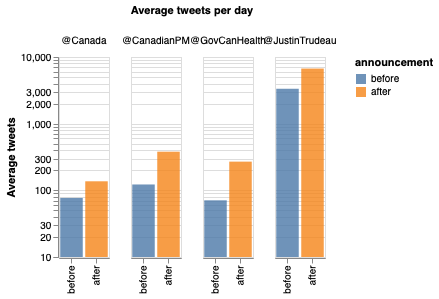

In [52]:
# plot volume of tweets in average per day
df_volume_2 = df.groupby(['account', 'announcement', 'day'])['tweet'].agg([pd.Series.count]).reset_index()
# df_volume_2
df_volume_2= df_volume_2.groupby(['account', 'announcement'])[['count']].mean().reset_index()

alt.Chart(df_volume_2, width=50, height=200).mark_bar(opacity=0.8).encode(
    x=alt.X('announcement', sort=['before', 'after'], title=""),
    y=alt.Y('count', title="Average tweets", scale=alt.Scale(type='log')), 
    color=alt.Color('announcement', sort=['before', 'after']),
    column=alt.Column('account', title="Average tweets per day"),
    tooltip=['account', 'announcement', 'count']
)

> When comparing the volume of the average tweets per day published before and after, we also find that Trudeau's announcement had an impact in the average number of tweets of users that mention any of the Canadian Government's account.

### Volume of actions and reactions: Reply, Retweet, Like and Quote

In [53]:
# dataframe with actions
df_volume = pd.DataFrame(df.groupby(['account', 'announcement'])\
                         ['replyCount', 'retweetCount', 'likeCount', 'quoteCount'].sum().stack())\
                         .reset_index().rename(columns = {'level_2':'type',0:'counts'})

In [54]:
def plot_volume(df, my_type='Reply'):
    """
    Funtion that uses altair to plot the volumen of a selected action 
    among: reply, retweet, like and quote.
    
    Parameters
    -------------
    df : (DataFrame)
        dataframe with three columns: twitter account, announcement, and a
        type of action.
    my_type : (str)
        type of action: reply, retweet, like and quote

    Returns
    -------------
    (plot) altair plot

    Example
    -------------
    plot_volume(df_volume, 'Like')
    """
    plot = alt.Chart(df[df.type == (my_type.lower()+"Count")], width=50, height=200).mark_bar(opacity=0.8).encode(
        x=alt.X('announcement', sort=['before', 'after'], title=""),
        y=alt.Y('counts', title="Counts", scale=alt.Scale(type='log')),
        color=alt.Color('announcement', sort=['before', 'after']),
        column=alt.Column('account', title=my_type)
    )
    return plot


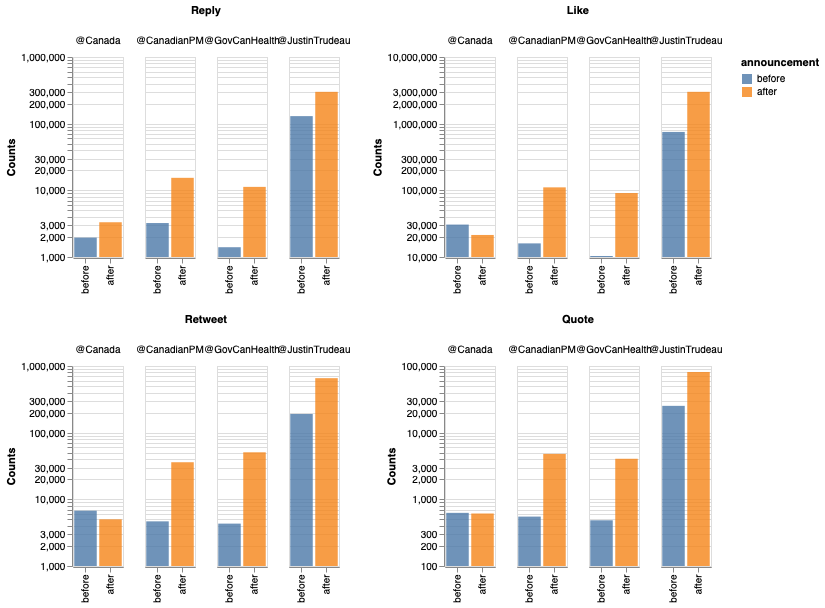

In [55]:
plot_1 = plot_volume(df_volume)
plot_2 = plot_volume(df_volume, 'Retweet')
plot_3 = plot_volume(df_volume, 'Like')
plot_4 = plot_volume(df_volume, 'Quote')

(plot_1 & plot_2) | (plot_3 & plot_4)

> Also, the annoucement had an impact in the actions and reactions of users, increasing the number of replies, likes, retweets and quotes when comparing this actions before and after the announcement.

## Final comments

The aim of this project is to measure the impact of the Government policies to help Canadians cope with the COVID-19.

For this reason, we compare the sentiment analysis on Canadians before and after Trudeau's first announcement on March 11<sup>th</sup>, 2020, where the Prime Minister outlined Canada’s whole-of-government response to COVID-19 outbreak.

To measure this impact download tweets from February 1<sup>st</sup> to April 30<sup>th</sup> mentioning any of the four selected Canadian Government's Twitter accounts ([@JustinTrudeau](https://twitter.com/JustinTrudeau?s=20), [@CanadianPM](https://twitter.com/CanadianPM), [@Canada](https://twitter.com/canada?lang=en) and [@GovCanHealth](https://twitter.com/govcanhealth?lang=en)), and compare the polarity and subjectivity of tweets published before and after the announcement.

On the analysis we find that the announcement on March 11<sup>th</sup>, and the following announcements of the Government policies related with COVID-19, had an impact in the volume and sentiment of tweets: 

- __Sentiment__: while the overall sentiment of tweets is positive, the announcement had different effect for the Government accounts. While the effect on @Canada account was a decrease in the trend of average polarity, in the other hand we identify a rise in trend of positive sentiment of tweets related with the Canadian Prime Minister (which means an increase in the trend of polarity levels of @CanadianPM and @JustinTrudeau accounts). The @GovCanHealth account was stable in trend of the mean polarity level before and after the announcement. 
- __Volume__: we observed an increase in the total number of tweets and the average tweets per day. Also, the noncement affected the volume of actions and reactions of users increasing the number of likes, replies, retweets and quotes.


In [56]:
print("Total time:", np.round((time.time() - START)/60, 2), "minutes.")

Total time: 1.49 minutes.
